In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_location = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname = font_location).get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

from tslearn.clustering import TimeSeriesKMeans


In [3]:
plt.style.use('fivethirtyeight')
np.random.seed(0)

In [4]:
industry= pd.read_excel('업종별 매출 실적_reduce.xlsx')
industry['시점'] = industry['시점'].astype('str').apply(lambda x: x[:4]+'-'+x[5:8])
industry['시점']=pd.to_datetime(industry['시점'])

In [5]:
types=list(industry.columns)[1:]

In [6]:
industry_temp=industry.copy()

industry_temp.drop(columns=['시점']
                ,inplace=True)


In [7]:

industry_temp=industry_temp.diff(12).rolling(4,min_periods=1,center=True).mean()#.transform(lambda x: (x-x.min())/(x.max() - x.min()))
industry_temp['시점']=industry['시점']
industry_temp.dropna(inplace=True)

In [8]:
industry_ma=industry.rolling(4,min_periods=1,center=True).mean()
industry_ma['시점']=industry['시점']

In [9]:
industry_af=industry_temp.iloc[25:]
industry_bf=industry_temp.iloc[1:25]

industry_bf.drop(columns=['시점']
                ,inplace=True)
industry_af.drop(columns=['시점']
                ,inplace=True)
industry_temp.drop(columns=['시점']
                ,inplace=True)

In [10]:
industry_bf.reset_index(drop=True, inplace=True)

industry_af.reset_index(drop=True, inplace=True)

In [11]:
industry_bf_T=industry_bf.T
industry_af_T=industry_af.T

#.transform(lambda x: (x-x.min())/(x.max() - x.min()))

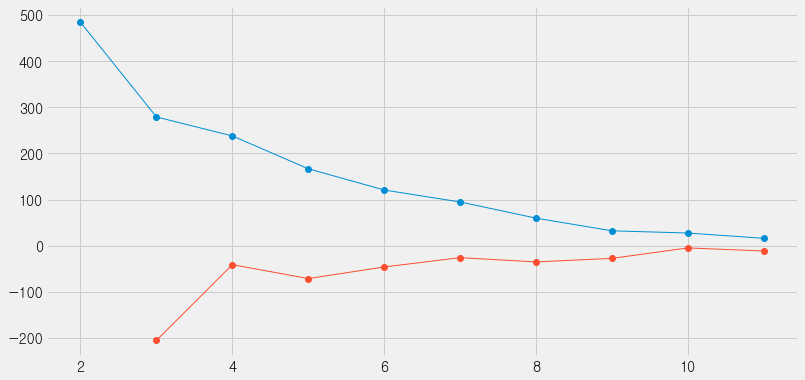

In [12]:
inertia_list = []

for i in range(2, 12):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=50,random_state=14).fit(industry_temp[1:25].reset_index(drop=True).T) # 시계열 데이터를 euclidean 기반으로 시계열 클러스터링을 진행합니다.
    inertia_list.append(km.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(2, 12)), inertia_list, marker='o', linewidth=1)
plt.plot(np.array(range(2, 12)), pd.Series(inertia_list).diff(), marker='o', linewidth=1)

plt.show()

In [13]:
np.random.seed(0)
n_cluster = 4# 하이퍼 파라메터 튜닝 결과 4개의 클러스터가 효율적입니다. 
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=50,random_state=14).fit(industry_bf_T) # 시계열 데이터를 euclidean 기반으로 시계열 클러스터링을 진행합니다.
rlt_tsm = km.predict(industry_bf_T)

my_dict_bf = dict((i, []) for i in range(0, n_cluster))

for i in range(len(rlt_tsm)):
    my_dict_bf[rlt_tsm[i]].append(list(types)[i])

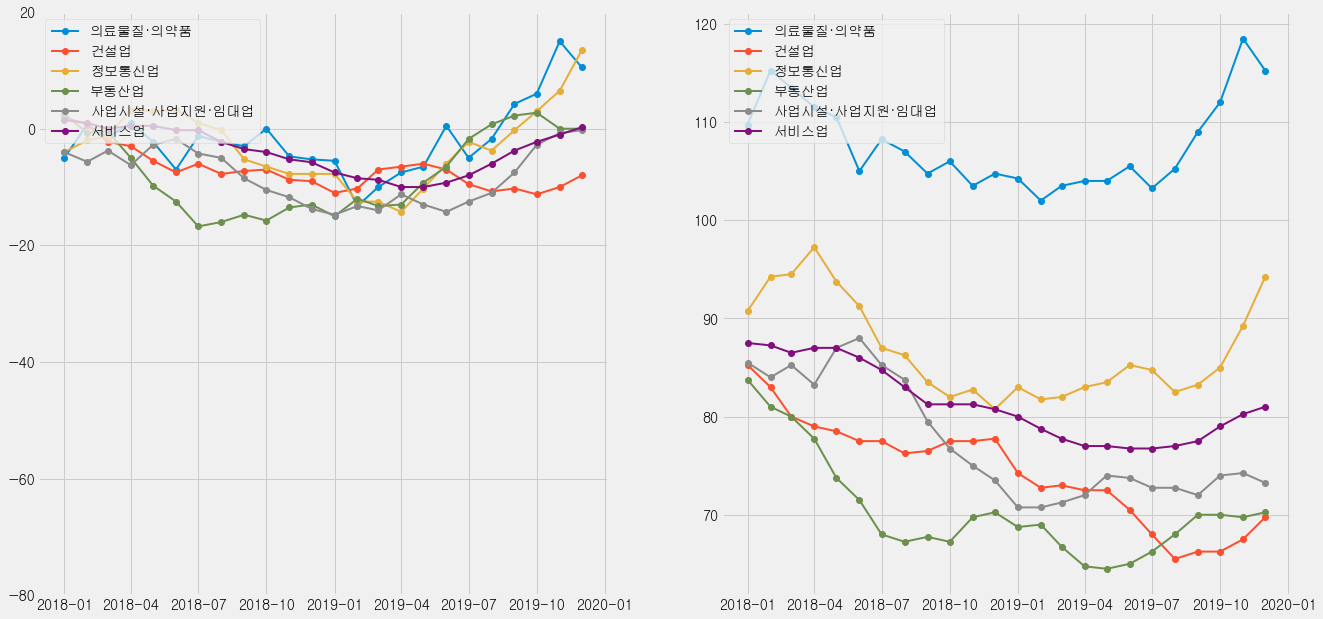

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_bf[0]:
    ax[0].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_temp[[i]][1:25]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_ma[[i]][12:36]),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

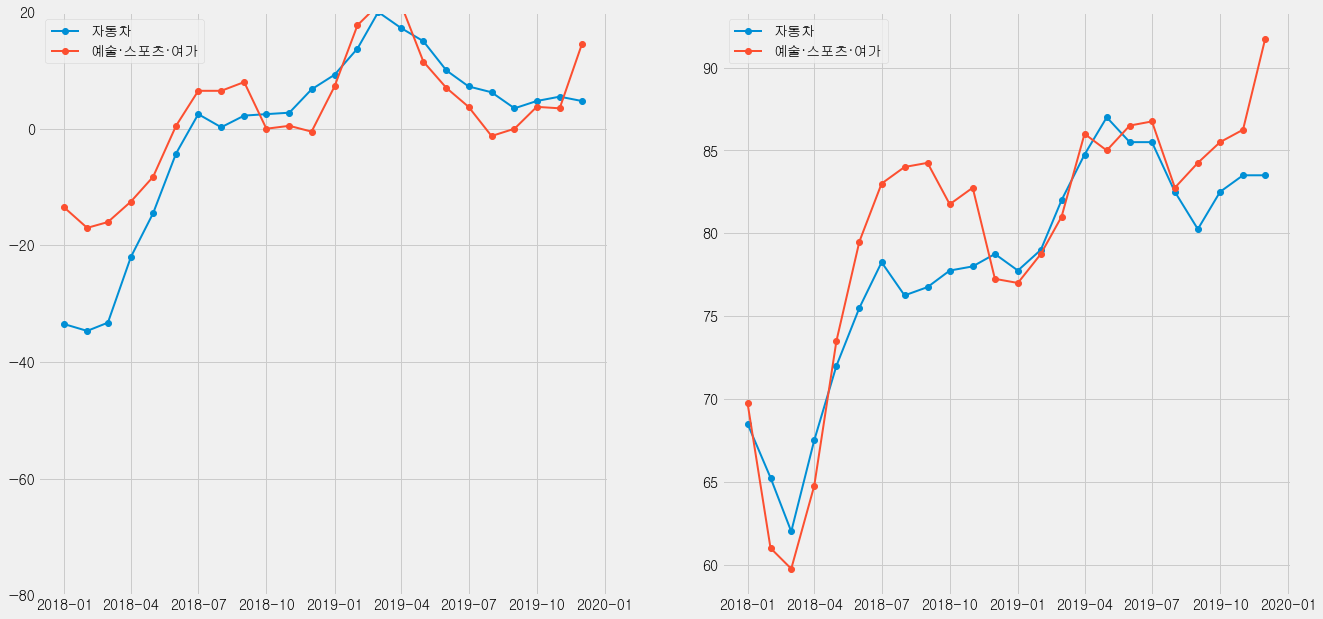

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_bf[1]:
    ax[0].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_temp[[i]][1:25]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_ma[[i]][12:36]),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

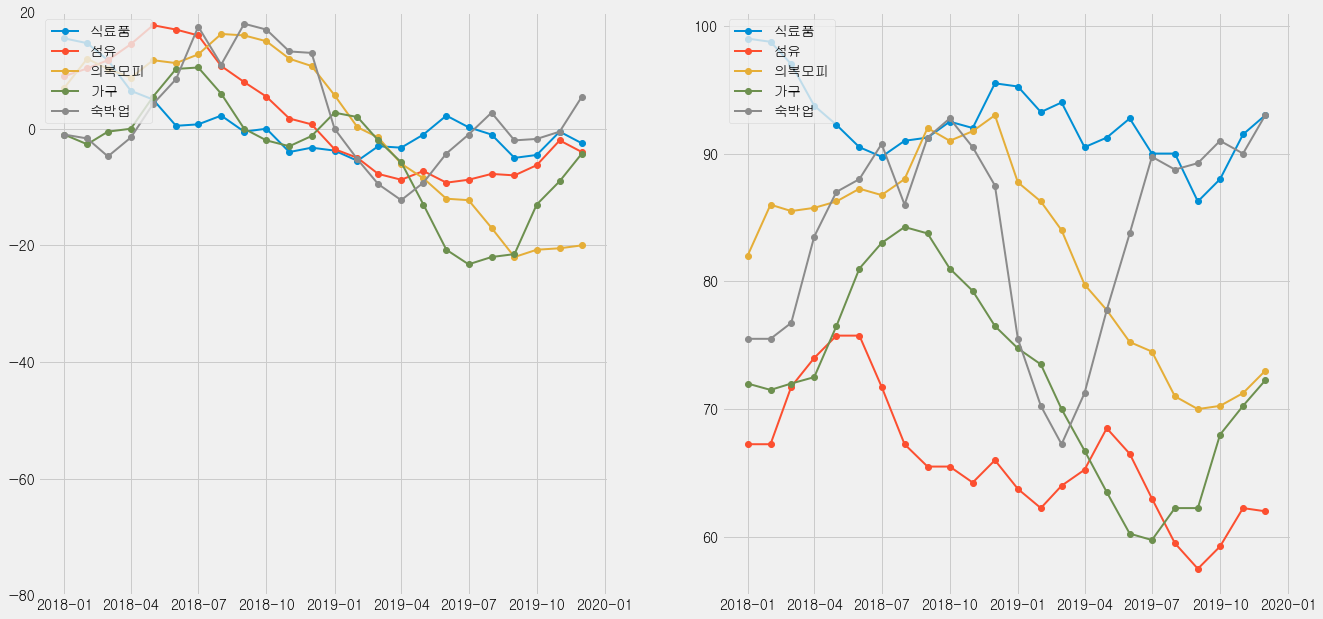

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_bf[2]:
    ax[0].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_temp[[i]][1:25]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_ma[[i]][12:36]),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

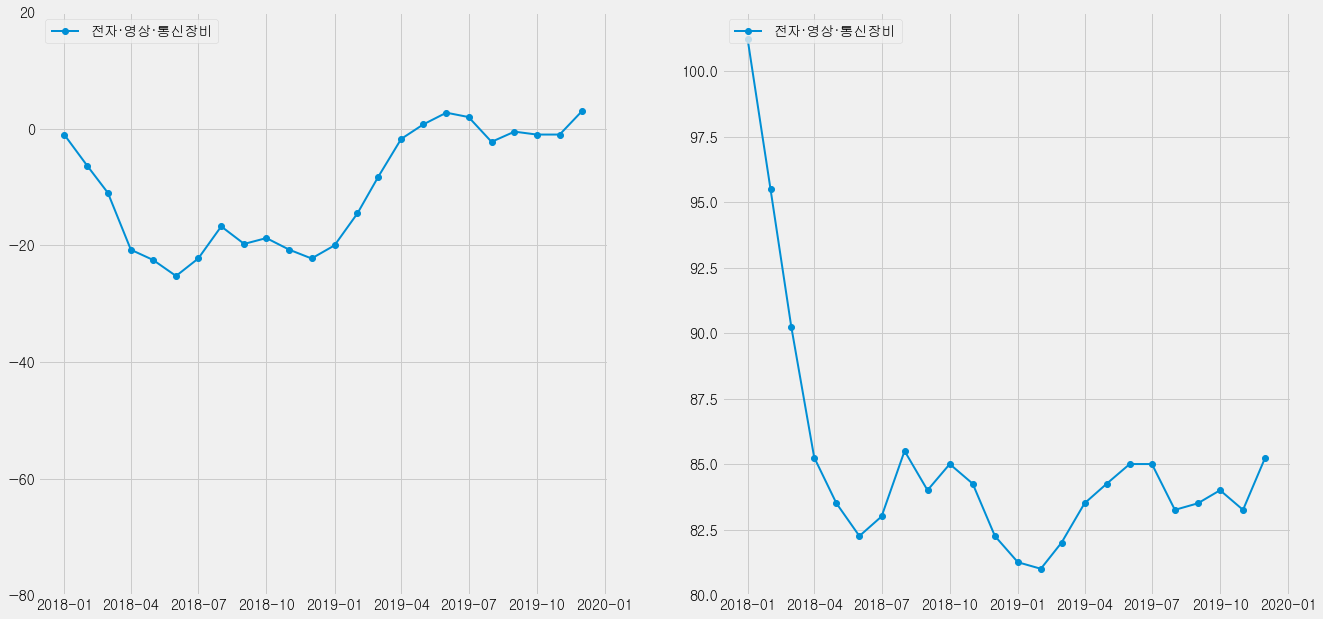

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_bf[3]:
    ax[0].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_temp[[i]][1:25]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[12:36].reset_index(drop=True)),np.array(industry_ma[[i]][12:36]),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

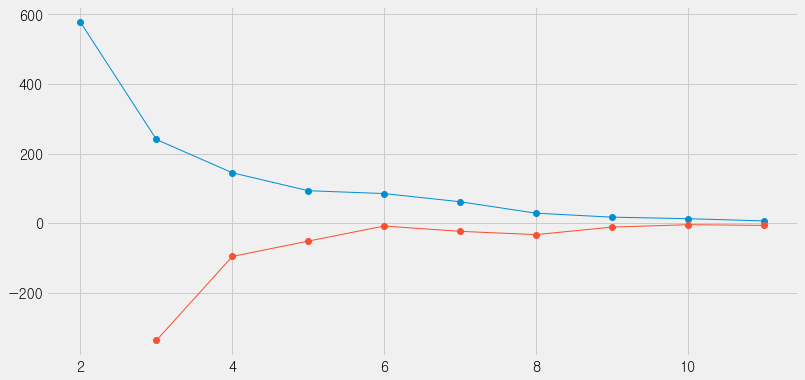

In [18]:
inertia_list = []

for i in range(2, 12):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=50,random_state=14).fit(industry_temp[25:].reset_index(drop=True).T) # 시계열 데이터를 euclidean 기반으로 시계열 클러스터링을 진행합니다.
    inertia_list.append(km.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(2, 12)), inertia_list, marker='o', linewidth=1)
plt.plot(np.array(range(2, 12)), pd.Series(inertia_list).diff(), marker='o', linewidth=1)

plt.show()

In [19]:
np.random.seed(0)
n_cluster = 6# 하이퍼 파라메터 튜닝 결과 4개의 클러스터가 효율적입니다. 
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=50,random_state=14).fit(industry_af_T) # 시계열 데이터를 euclidean 기반으로 시계열 클러스터링을 진행합니다.
rlt_tsm = km.predict(industry_af_T)

my_dict_af = dict((i, []) for i in range(0, n_cluster))

for i in range(len(rlt_tsm)):
    my_dict_af[rlt_tsm[i]].append(list(types)[i])

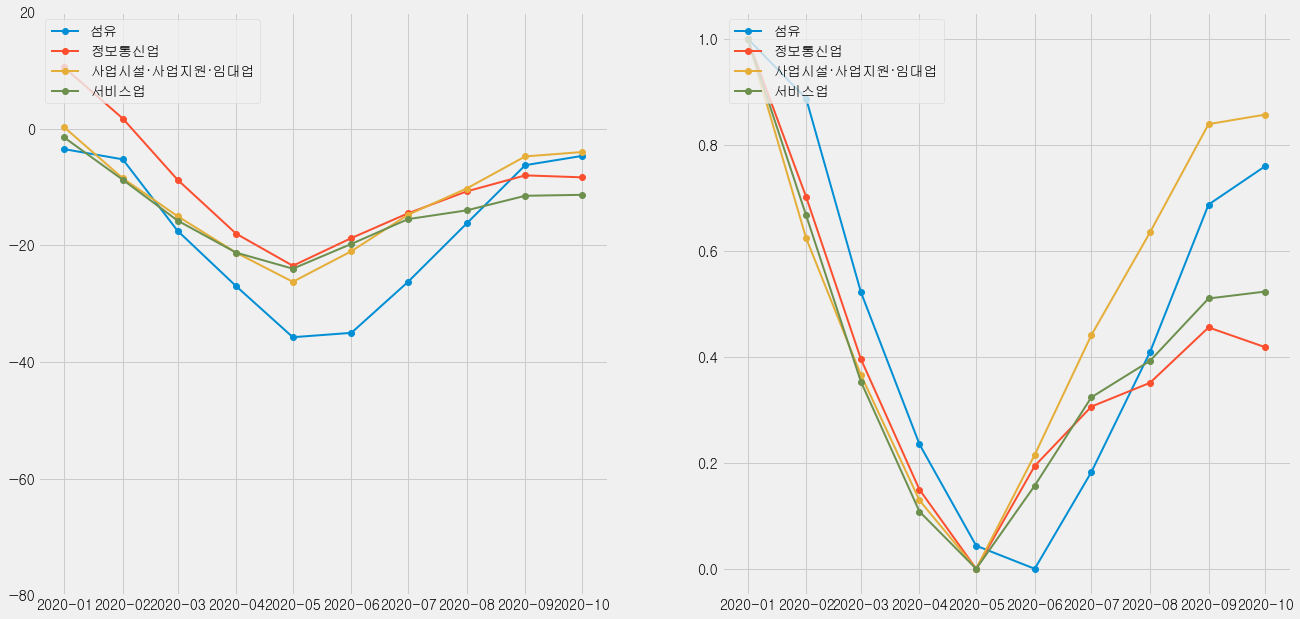

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_af[0]:
    ax[0].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_temp[[i]][25:]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_ma[[i]][36:].transform(lambda x: (x-x.min())/(x.max() - x.min()))),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

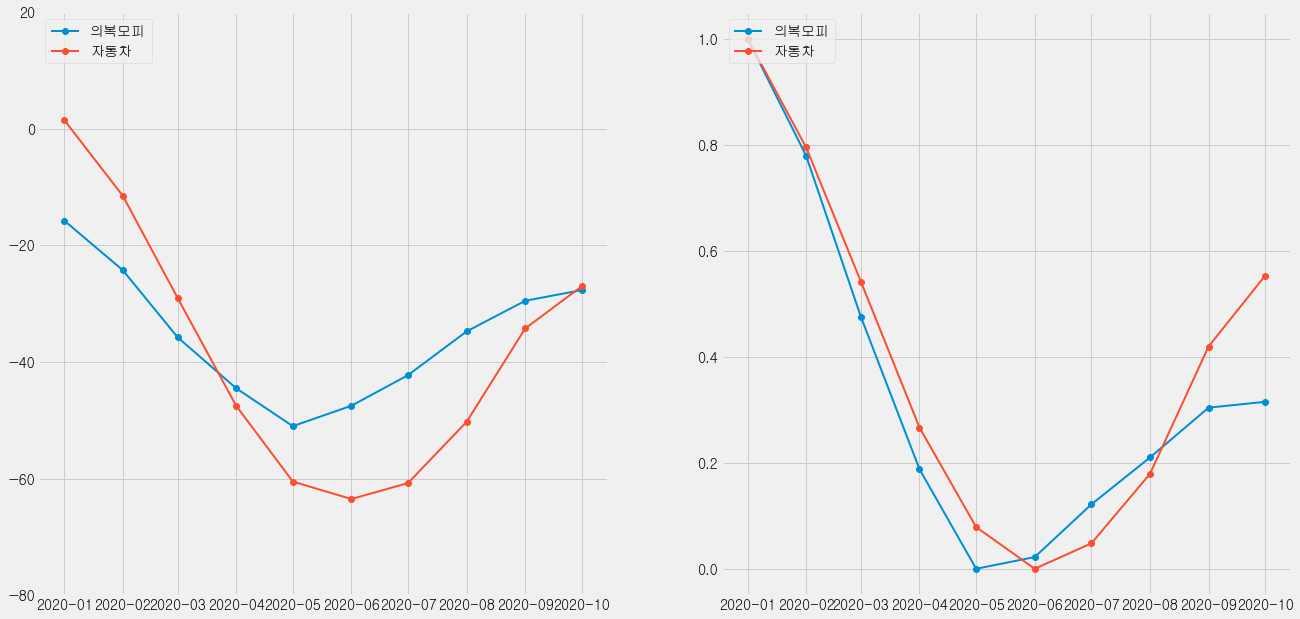

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_af[1]:
    ax[0].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_temp[[i]][25:]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_ma[[i]][36:].transform(lambda x: (x-x.min())/(x.max() - x.min()))),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

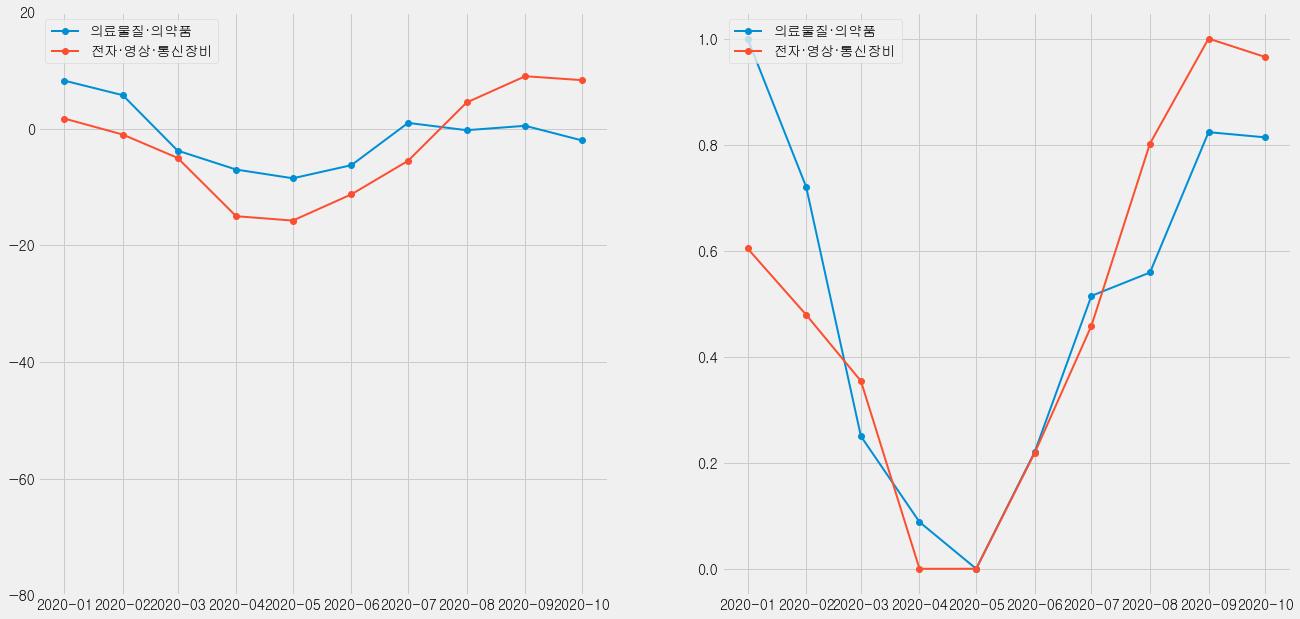

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_af[2]:
    ax[0].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_temp[[i]][25:]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_ma[[i]][36:].transform(lambda x: (x-x.min())/(x.max() - x.min()))),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

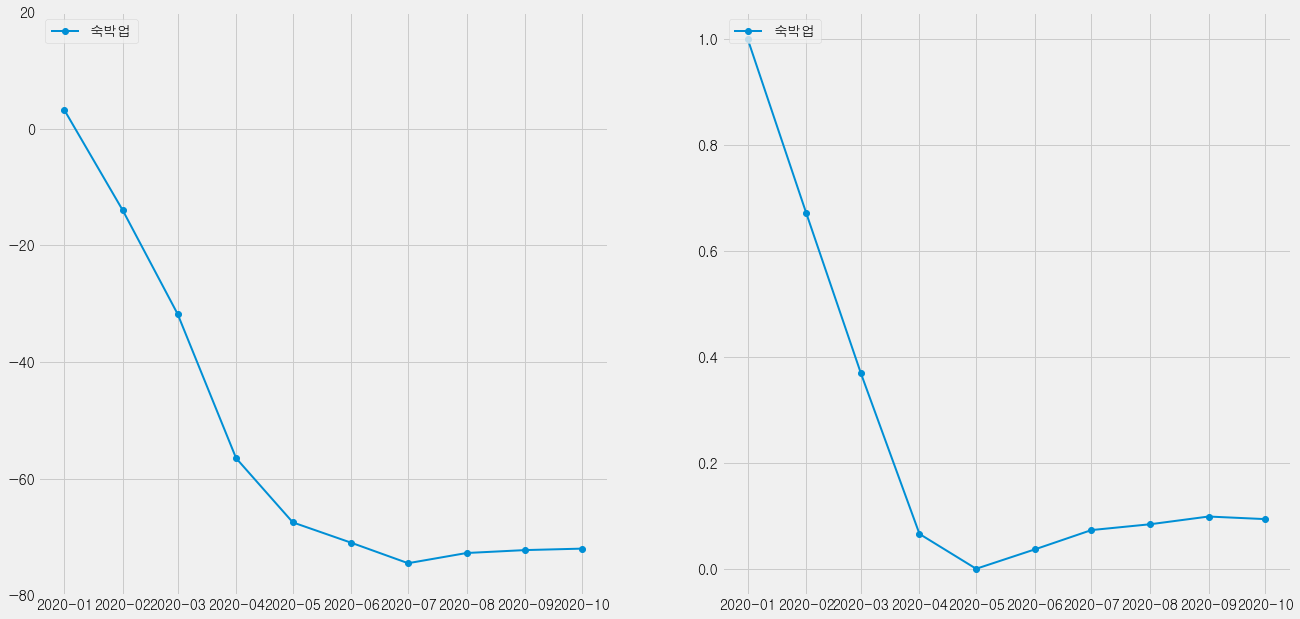

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_af[3]:
    ax[0].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_temp[[i]][25:]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_ma[[i]][36:].transform(lambda x: (x-x.min())/(x.max() - x.min()))),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

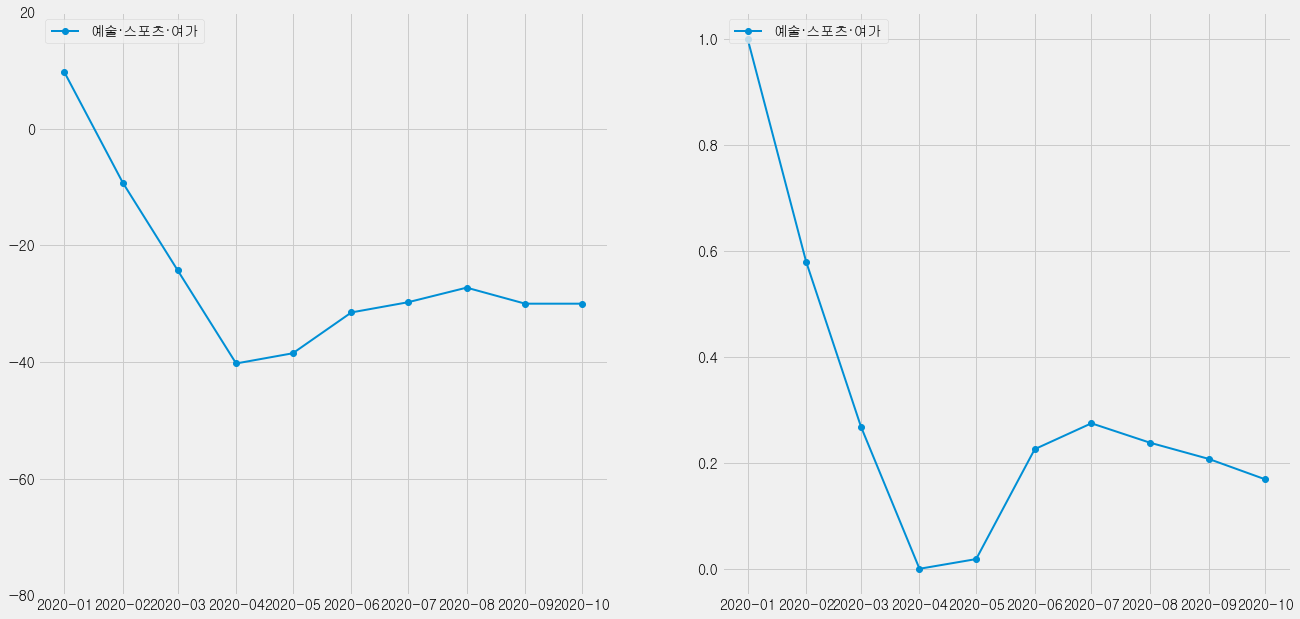

In [24]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_af[4]:
    ax[0].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_temp[[i]][25:]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_ma[[i]][36:].transform(lambda x: (x-x.min())/(x.max() - x.min()))),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

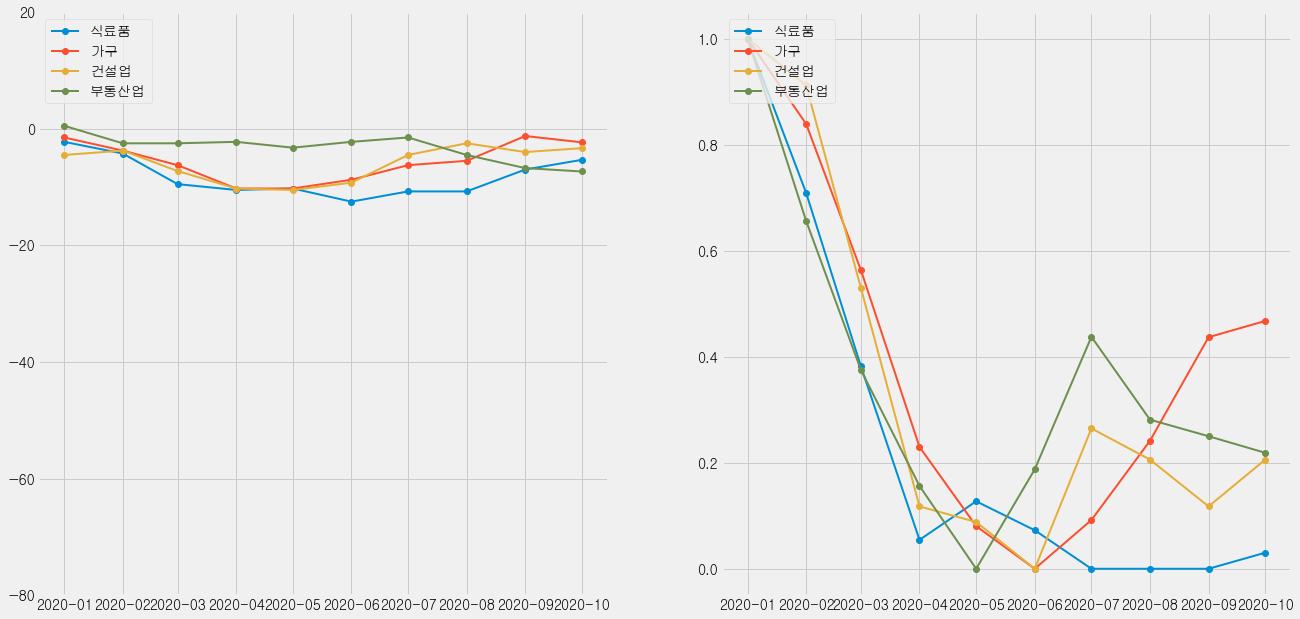

In [25]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_ylim(-80,20)
for i in my_dict_af[5]:
    ax[0].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_temp[[i]][25:]),marker='o', linewidth=2,label=i)
    ax[1].plot(np.array(industry[['시점']].iloc[36:].reset_index(drop=True)),np.array(industry_ma[[i]][36:].transform(lambda x: (x-x.min())/(x.max() - x.min()))),marker='o', linewidth=2,label=i)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

In [26]:
my_dict_af

{0: ['섬유', '정보통신업', '사업시설·사업지원·임대업', '서비스업'],
 1: ['의복모피', '자동차'],
 2: ['의료물질·의약품', '전자·영상·통신장비'],
 3: ['숙박업'],
 4: ['예술·스포츠·여가'],
 5: ['식료품', '가구', '건설업', '부동산업']}

In [27]:
my_dict_bf

{0: ['의료물질·의약품', '건설업', '정보통신업', '부동산업', '사업시설·사업지원·임대업', '서비스업'],
 1: ['자동차', '예술·스포츠·여가'],
 2: ['식료품', '섬유', '의복모피', '가구', '숙박업'],
 3: ['전자·영상·통신장비']}